In [1]:
import warnings #to suppress warnings due to very not compatible numpy version
with warnings.catch_warnings():  
    warnings.filterwarnings("ignore",category=FutureWarning)
    import math
    import numpy as np
    import h5py
    import matplotlib.pyplot as plt
    import tensorflow as tf
    from tensorflow.python.framework import ops

%matplotlib inline
np.random.seed(1)

def load_dataset():
    train_dataset = h5py.File('./data/train_signs.h5', "r")
    test_dataset = h5py.File('./data/test_signs.h5', "r")
    
    train_set_x_orig = np.array(train_dataset["train_set_x"][:])
    train_set_y_orig = np.array(train_dataset["train_set_y"][:])
    test_set_x_orig = np.array(test_dataset["test_set_x"][:])
    test_set_y_orig = np.array(test_dataset["test_set_y"][:])
    classes = np.array(test_dataset["list_classes"][:])
    
    train_set_y_orig = np.eye(6)[train_set_y_orig]
    test_set_y_orig = np.eye(6)[test_set_y_orig]
    
    
    return train_set_x_orig/255., train_set_y_orig, test_set_x_orig/255., test_set_y_orig, classes

number of training examples = 1080
number of test examples = 120
X_train shape: (1080, 64, 64, 3)
Y_train shape: (1080, 6)
X_test shape: (120, 64, 64, 3)
Y_test shape: (120, 6)


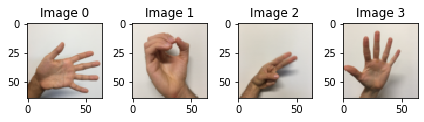

In [2]:
X_train, Y_train, X_test, Y_test, classes = load_dataset()

#Let's see a sample image
fig, axarr = plt.subplots(1,4)
for indexi in range(4):
    axarr[indexi].set_title('Image '+ str(indexi))
    axarr[indexi].imshow(X_train[indexi])
    indexi = indexi + 1
fig.tight_layout()

print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

In [3]:
tf.set_random_seed(1)   #to be consistent among many runs

# Create placeholders for input and output variables
(totalExamples, n_H0, n_W0, n_C0) = X_train.shape
(totalExamples, n_y) = Y_train.shape

def create_placeholders(n_H, n_W, n_C, n_Y):
    X = tf.placeholder(tf.float32, shape=[None,n_H,n_W,n_C]) #none, because we will figure out the mini batch sizes
    Y = tf.placeholder(tf.float32, shape=[None,n_Y])
    return X,Y

def init_parameters():
    # set up weights
    tf.set_random_seed(1)
    W1 = tf.get_variable("W1", [4,4,3,8], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    W2 = tf.get_variable("W2", [2,2,8,16], initializer=tf.contrib.layers.xavier_initializer(seed=0))
    return {"W1": W1, "W2": W2}

### We will be implementing following CNN now :
    CONV2D ( stride=1, "SAME" ) -> RELU -> MAXPOOL ( 8x8, stride=8, "SAME" ) -> CONV2D ( stride=1, "SAME" )-> RELU -> MAXPOOL ( 4x4, stride=4, "SAME" ) -> FLATTEN -> FULLYCONNECTED -> SIGMOID

In [4]:
def forward_propagation(X, parameters):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    Z1 = tf.nn.conv2d(X, W1, strides=[1,1,1,1],padding='SAME')
    A1 = tf.nn.relu(Z1)
    P1 = tf.nn.max_pool(A1,ksize=[1,8,8,1], strides=[1,8,8,1], padding='SAME')
    Z2 = tf.nn.conv2d(P1, W2, strides=[1,1,1,1], padding='SAME')
    A2 = tf.nn.relu(Z2)
    P2 = tf.nn.max_pool(A2,ksize=[1,4,4,1], strides=[1,4,4,1], padding='SAME')
    P2 = tf.contrib.layers.flatten(P2)
    Z3 = tf.contrib.layers.fully_connected(P2, 6, activation_fn=None) #softmax will be part of cost function
    return Z3

def compute_cost(Z3, Y):
    return tf.reduce_mean( tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y) )

In [5]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.004,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    print('\n\nLearning rate is {} and total iterations {}'.format(learning_rate, num_epochs))
    ops.reset_default_graph()
    tf.set_random_seed(1)
    numpy_seed = 3
    (m, n_H, n_W, n_C) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []
    
    X, Y = create_placeholders(n_H, n_W, n_C, n_y)
    parameters = init_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)

    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        writer = tf.summary.FileWriter('./graphs', sess.graph) #let's write the graph for visualization!
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size)
            numpy_seed = numpy_seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, numpy_seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], feed_dict={X:minibatch_X, Y:minibatch_Y})
                minibatch_cost += temp_cost / num_minibatches

            if print_cost == True and epoch % 15 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    m = X.shape[0]
    mini_batches = []
    np.random.seed(seed)
    
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches



Learning rate is 0.004 and total iterations 100
Cost after epoch 0: 1.929691
Cost after epoch 15: 0.959531
Cost after epoch 30: 0.480920
Cost after epoch 45: 0.345563
Cost after epoch 60: 0.245297
Cost after epoch 75: 0.212981
Cost after epoch 90: 0.148815


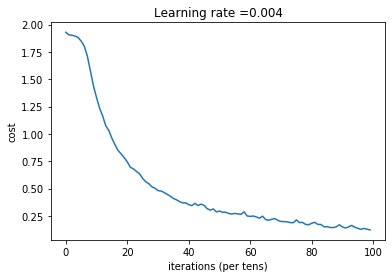

Train Accuracy: 0.97962964
Test Accuracy: 0.9166667


In [7]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)

### Let's see importance of learning rate : 0.001 and 1.0 - if we have smaller learning rate, convergence will be slow. If we have bigger learning rate, we may oscillate around optimal solution, and may end up with very little accuracy after same number of iterations!



Learning rate is 0.001 and total iterations 100
Cost after epoch 0: 1.971088
Cost after epoch 15: 1.854860
Cost after epoch 30: 1.389846
Cost after epoch 45: 0.886125
Cost after epoch 60: 0.673602
Cost after epoch 75: 0.554584
Cost after epoch 90: 0.468007


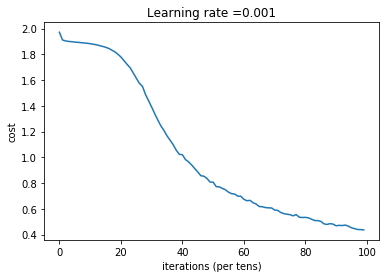

Train Accuracy: 0.85925925
Test Accuracy: 0.78333336


Learning rate is 1.0 and total iterations 100
Cost after epoch 0: 59.613843
Cost after epoch 15: 1.951399
Cost after epoch 30: 1.925679
Cost after epoch 45: 1.982942
Cost after epoch 60: 1.942182
Cost after epoch 75: 1.969529
Cost after epoch 90: 1.945178


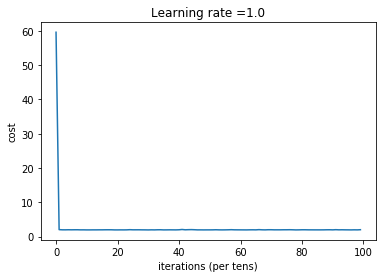

Train Accuracy: 0.16666667
Test Accuracy: 0.16666667


In [8]:

_, _, parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=0.001)
_, _, parameters = model(X_train, Y_train, X_test, Y_test, learning_rate=1.0)

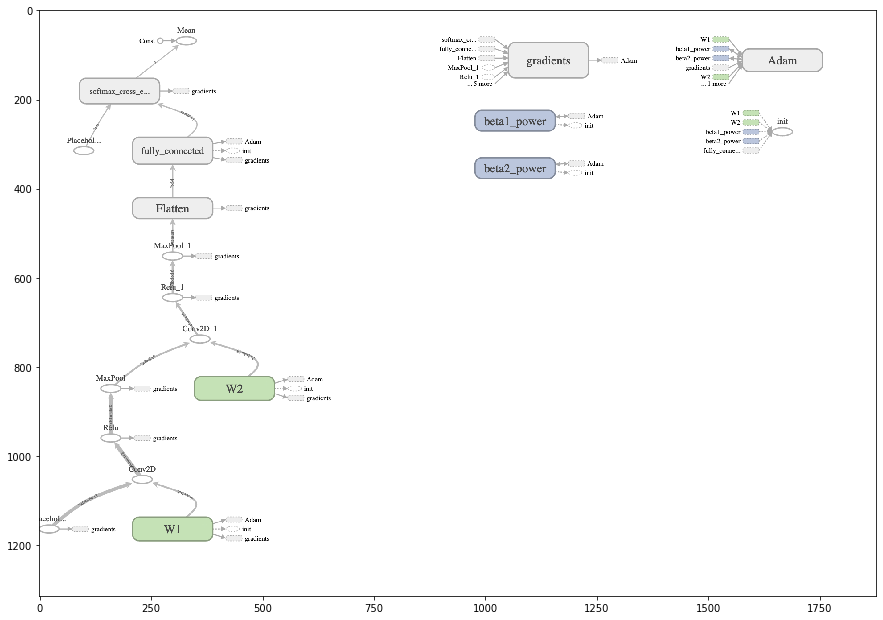

In [9]:
#Let's try to visualize the tensorflow graph we created - note that we stored it leveraging tensorboard
plt.figure(num=None, figsize=(15, 15))
plt.imshow(plt.imread('./data/CNN_hand_gestures_graph.png')) #may not be clear in notebook, but great tool to visualize your network